In [ ]:
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths
DATASET_DIR = "Data"         # your input folder
OUTPUT_DIR = "output"           # where train/test will be created
TEST_SIZE = 0.2                 # 20% test split
SEED = 42

# Create output structure
train_dir = os.path.join(OUTPUT_DIR, "train")
test_dir = os.path.join(OUTPUT_DIR, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def is_48x48(path):
    try:
        with Image.open(path) as img:
            return img.size == (48, 48)
    except:
        return False

# Loop over each class folder
for cls in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, cls)
    if not os.path.isdir(class_path):
        continue

    # Filter only 48x48 files
    all_files = [
        f for f in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, f))
        and is_48x48(os.path.join(class_path, f))
    ]

    if not all_files:
        print(f"Skipping class '{cls}'—no 48x48 images.")
        continue

    # Train-test split
    train_files, test_files = train_test_split(all_files, test_size=TEST_SIZE, random_state=SEED)

    # Create class dirs in output
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Copy train files
    for f in train_files:
        shutil.copy(
            os.path.join(class_path, f),
            os.path.join(train_dir, cls, f)
        )

    # Copy test files
    for f in test_files:
        shutil.copy(
            os.path.join(class_path, f),
            os.path.join(test_dir, cls, f)
        )

print("Done! Dataset split with only 48x48 images.")


In [ ]:
import os
import numpy as np
from PIL import Image

def load_dataset(root):
    images = []
    labels = []
    class_names = sorted(os.listdir(root))
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}

    for cls in class_names:
        class_path = os.path.join(root, cls)
        if not os.path.isdir(class_path):
            continue

        for f in os.listdir(class_path):
            path = os.path.join(class_path, f)
            if not os.path.isfile(path):
                continue

            # Load image and convert to grayscale
            try:
                img = Image.open(path).convert("L")   # "L" = 8-bit grayscale
                arr = np.array(img, dtype=np.uint8)   # shape (48, 48)
            except:
                continue

            images.append(arr)
            labels.append(class_to_idx[cls])

    return np.array(images), np.array(labels)

# Load both sets
train_images, train_labels = load_dataset("output/train")
test_images, test_labels = load_dataset("output/test")

# Save everything into one file
np.savez_compressed(
    "dataset.npz",
    train_images=train_images,
    train_labels=train_labels,
    test_images=test_images,
    test_labels=test_labels
)

print("Saved dataset.npz")


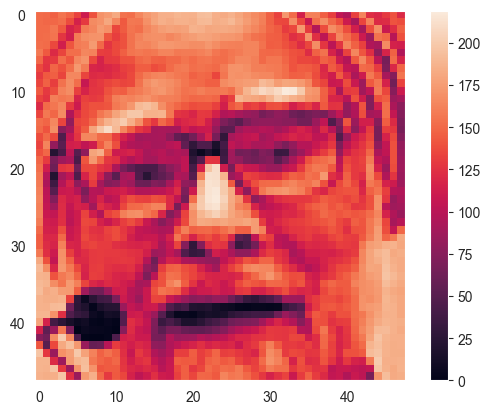

In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def my_saved_dataset(path="dataset.npz"):
    data = np.load(path)
    return (data["train_images"], data["train_labels"]), (data["test_images"], data["test_labels"])

(train_images, train_labels), (test_images, test_labels) = my_saved_dataset()
# Class names are simply digits 0-9
class_names = ['Angry','Fear','Happy','Sad','Surprise']

# Inspect the first image in the training set
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

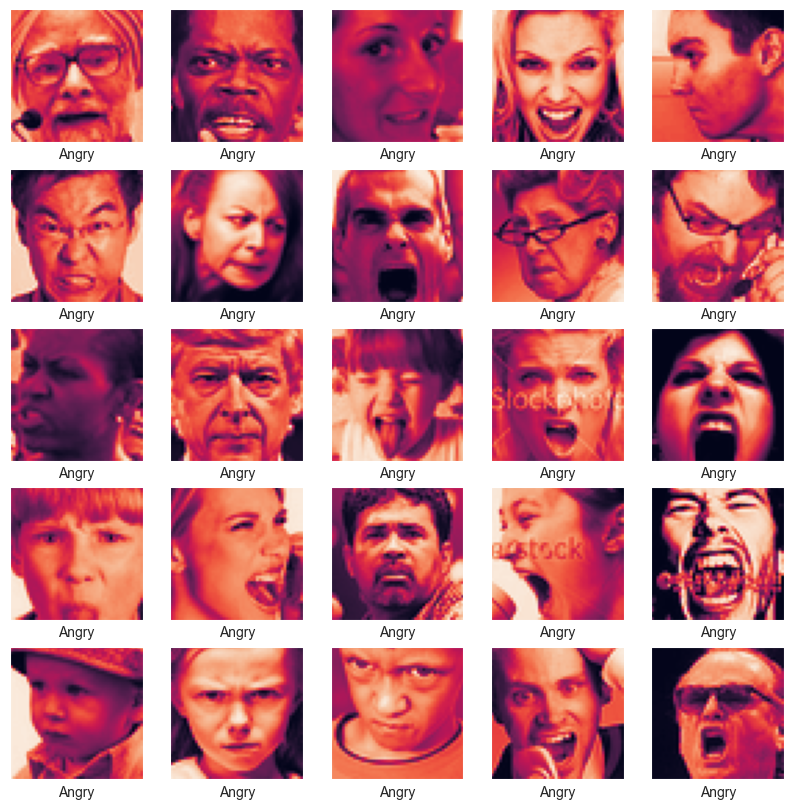

In [54]:
# Scale values to a range of 0 to 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Display the first 25 images to verify the format
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [55]:
# Set up the layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),

    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(5)# Output layer (returns logits for 10 classes)
])

In [56]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,405 (1.79 MB)

 Trainable params: 470,405 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.3323 - loss: 1.5250
Epoch 2/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.4966 - loss: 1.2025
Epoch 3/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.5688 - loss: 1.0419
Epoch 4/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.6265 - loss: 0.9316
Epoch 5/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6695 - loss: 0.8331
Epoch 6/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.7138 - loss: 0.7323
Epoch 7/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.7520 - loss: 0.6430
Epoch 8/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.7922 - loss: 0.5497
Epoch 9/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.8261 - loss: 0.4709
Epoch 10/10
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.8533 - loss: 0.3998


In [ ]:
# Compare how the model performs on the test dataset
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
# Attach a softmax layer to convert logits to probabilities
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

# Check the first prediction
print(predictions[0])
print("Predicted label:", np.argmax(predictions[0]))

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color=color)


def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')




In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()